In [199]:
#Imports
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import copy
import pfr
import time
from sklearn.grid_search import GridSearchCV

In [200]:
# reupload all data to have as one dataset again
completedf1 = pd.concat([pd.read_csv('0204plays.csv'),pd.read_csv('0507plays.csv'),pd.read_csv('0810plays.csv'),pd.read_csv('1114plays.csv')])

#(remove 2002, because it has served it's purpose of creating 2003 priors)
completedf = completedf1[completedf1['year']>2002].reset_index(drop=True)

# define number of plays in df, which is now our finalized dataset with all variables
plays = len(completedf)

In [201]:
print completedf.shape
completedf.head(2)

lcols = ["distToGoal","inDown3","inDown2","inDown1","inQuarter4","inQuarter3","inQuarter2","inQuarter1","secsElapsedInHalf","margin","yds_to_go","addscore","tm_TO_left","opp_TO_left","inFGRange", "inRedZone", "tm_winprob","inLast3minHalf", "tm_prev_yr_pass","tm_in_season_pass","tm_in_game_pass","StartofDrive","prevWasPass"]

(397349, 139)


In [202]:
def masking(df,itrain,itest):    
    mask=np.ones(df.shape[0], dtype='int')
    mask[itrain]=1
    mask[itest]=0
    mask = (mask==1)
    return mask

In [203]:
def cv_optimize(clf, parameters, X, y, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

In [204]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.6f" % (training_accuracy)
    print "Accuracy on test data:     %0.6f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest, test_accuracy

In [257]:
def runsvm2(df,lcols,mask,Cs):    
    from sklearn.svm import LinearSVC
    clfsvm_lin=LinearSVC(loss="hinge")
    parameters = {"C": Cs}
    # could add njobs to the mix to run them in parallel
    clfsvm_lin, Xtrainlin, ytrainlin, Xtestlin, ytestlin,_ = do_classify(clfsvm_lin, parameters, df, lcols, u'RESP', 1, mask=mask)
    return clfsvm_lin, Xtrainlin, ytrainlin, Xtestlin, ytestlin,_

def runsvc2(df,lcols,mask,Cs):    
    from sklearn.svm import SVC
    clfsvm_orig = SVC()
    parameters = {"C": Cs}
    # could add njobs to the mix to run them in parallel
    clfsvm_orig, Xtrainorig, ytrainorig, Xtestorig, ytestorig,_ = do_classify(clfsvm_orig, parameters, df, lcols, u'RESP', 1, mask=mask)
    return clfsvm_orig, Xtrainorig, ytrainorig, Xtestorig, ytestorig,_

def randforest(df,lcols,mask):    
    from sklearn.ensemble import RandomForestClassifier
    clfForest = RandomForestClassifier()
    parameters = {"n_estimators": np.arange(1,100,5)}
    # could add njobs to the mix to run them in parallel
    clfForest, Xtrainrf, ytrainrf, Xtestrf, ytestrf,_ = do_classify(clfForest, parameters, df, lcols, u'RESP', 1, mask=mask, score_func='f1')
    return clfForest, Xtrainrf, ytrainrf, Xtestrf, ytestrf,_

def gradboost(df,lcols,mask):
    from sklearn.ensemble import GradientBoostingClassifier
    clfGB = GradientBoostingClassifier()
    parameters = {"max_depth": range(1, 8)}
    clfGB, Xtraingb, ytraingb, Xtestgb, ytestgb,_ = do_classify(clfGB, parameters, df, lcols, u'RESP', 1, mask=mask, score_func='f1')
    return clfGB, Xtraingb, ytraingb, Xtestgb, ytestgb,_

def adaboost(clfForest,df,lcols,mask):
    from sklearn.ensemble import AdaBoostClassifier
    clfAda = AdaBoostClassifier(base_estimator=clfForest)
    parameters = {"n_estimators": np.arange(1, 100, 5)}
    clfAda, Xtrainada, ytrainada, Xtestada, ytestada,_ = do_classify(clfAda, parameters, df, lcols, u'RESP', 1, mask=mask, score_func='f1')
    return clfAda, Xtrainada, ytrainada, Xtestada, ytestada,_

In [258]:
def plot_features(clfForest,lcols,name):
    importance_list = clfForest.feature_importances_
    importance_list, name_list = zip(*sorted(zip(importance_list, lcols)))
    width = 0.8
    yTickPos = np.arange(len(importance_list))
    yBarPos = yTickPos - (width/2.0)
    plt.barh(yBarPos,importance_list,align='center', color="lightskyblue")
    plt.yticks(yTickPos, name_list)
    plt.ylim((min(yTickPos)-0.6, max(yTickPos)+0.6))
    plt.grid(False)
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.title('Relative Importance of Each Feature for %s' % str(name))
    plt.show()
    

def plot_decision_surface(clf, X_train, Y_train):
    plot_step=0.1
    
    if X_train.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columnns!")
    
    x_min, x_max = X_train[:, 0].min() - plot_step, X_train[:, 0].max() + plot_step
    y_min, y_max = X_train[:, 1].min() - plot_step, X_train[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))

    clf.fit(X_train,Y_train)
    if hasattr(clf, 'predict_proba'):
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])    
    
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Reds)
    plt.scatter(X_train[:,0],X_train[:,1],c=Y_train,cmap=plt.cm.Paired, alpha=0.40, s=20)
    plt.show()
    
    print type(X_train[:, 0].min()), type(plot_step)
    

def plot_rf(clfForest,label,lcols,df):
    xt = [lcols[e] for e in clfForest.feature_importances_.argsort()[::-1][0:2]]
    X_imp = df[xt].values
    Y = df.RESP.values
    plt.title(label)
    plt.xlabel(xt[0])
    plt.ylabel(xt[1])
    plt.grid(False)
    plot_decision_surface(clfForest, X_imp, Y)

In [253]:
year = 2014 # whatever year you want to test
df = completedf[completedf['year']==year]

In [208]:
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(df.shape[0]), train_size=0.7)
mask = masking(df,itrain,itest)
Cs=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0] # try fewer if doesnt finish up

In [209]:
# run linear svm model
clfsvm_lin, Xtrainlin, ytrainlin, Xtestlin, ytestlin,_ = runsvm2(df, lcols, mask, Cs)

using mask
BEST {'C': 0.001} 0.628292394199 [mean: 0.62829, std: 0.01645, params: {'C': 0.001}, mean: 0.61320, std: 0.04503, params: {'C': 0.01}, mean: 0.61582, std: 0.01367, params: {'C': 0.1}, mean: 0.57798, std: 0.05633, params: {'C': 1.0}, mean: 0.57561, std: 0.05616, params: {'C': 10.0}, mean: 0.57671, std: 0.07231, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.601911
Accuracy on test data:     0.601953
[[ 113 3978]
 [  57 5989]]
########################################################


/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [210]:
# run svc model
clfsvm_orig, Xtrainorig, ytrainorig, Xtestorig, ytestorig,_ = runsvc2(df, lcols, mask, Cs)

using mask
BEST {'C': 1.0} 0.597133555997 [mean: 0.59701, std: 0.00005, params: {'C': 0.001}, mean: 0.59701, std: 0.00005, params: {'C': 0.01}, mean: 0.59701, std: 0.00005, params: {'C': 0.1}, mean: 0.59713, std: 0.00177, params: {'C': 1.0}, mean: 0.59506, std: 0.00368, params: {'C': 10.0}, mean: 0.59519, std: 0.00367, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.995603
Accuracy on test data:     0.592187
[[ 136 3955]
 [ 179 5867]]
########################################################


/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [211]:
# run logistic regression with lasso model
from sklearn.linear_model import LogisticRegression
clflog, Xtrain1, ytrain1, Xtest1, ytest1,_ = do_classify(LogisticRegression(penalty="l1"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df, lcols, u'RESP', 1, mask=mask)

using mask
BEST {'C': 10} 0.668456432588 [mean: 0.59798, std: 0.01162, params: {'C': 0.001}, mean: 0.65818, std: 0.01219, params: {'C': 0.01}, mean: 0.66765, std: 0.01119, params: {'C': 0.1}, mean: 0.66812, std: 0.00949, params: {'C': 1}, mean: 0.66846, std: 0.00935, params: {'C': 10}, mean: 0.66765, std: 0.00968, params: {'C': 100}]
############# based on standard predict ################
Accuracy on training data: 0.669175
Accuracy on test data:     0.670218
[[2073 2018]
 [1325 4721]]
########################################################


/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [212]:
# run logistic model 2
clflog2, Xtrain2, ytrain2, Xtest2, ytest2,_ = do_classify(LogisticRegression(penalty="l2"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df, lcols, u'RESP', 1, mask=mask)

using mask
BEST {'C': 10} 0.668456432588 [mean: 0.64998, std: 0.00823, params: {'C': 0.001}, mean: 0.66440, std: 0.01108, params: {'C': 0.01}, mean: 0.66761, std: 0.00969, params: {'C': 0.1}, mean: 0.66833, std: 0.00946, params: {'C': 1}, mean: 0.66846, std: 0.00851, params: {'C': 10}, mean: 0.66799, std: 0.00954, params: {'C': 100}]
############# based on standard predict ################
Accuracy on training data: 0.668710
Accuracy on test data:     0.670119
[[2080 2011]
 [1333 4713]]
########################################################


/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [213]:
#Random forest classifier
clfForest, Xtrainrf, ytrainrf, Xtestrf, ytestrf,_ = randforest(df,lcols,mask)

using mask
BEST {'n_estimators': 81} 0.746282979636 [mean: 0.67632, std: 0.00282, params: {'n_estimators': 1}, mean: 0.68421, std: 0.00635, params: {'n_estimators': 6}, mean: 0.72702, std: 0.00391, params: {'n_estimators': 11}, mean: 0.71918, std: 0.00499, params: {'n_estimators': 16}, mean: 0.73546, std: 0.00878, params: {'n_estimators': 21}, mean: 0.73265, std: 0.00572, params: {'n_estimators': 26}, mean: 0.74058, std: 0.00591, params: {'n_estimators': 31}, mean: 0.73353, std: 0.00553, params: {'n_estimators': 36}, mean: 0.74192, std: 0.00670, params: {'n_estimators': 41}, mean: 0.73903, std: 0.00768, params: {'n_estimators': 46}, mean: 0.74400, std: 0.00700, params: {'n_estimators': 51}, mean: 0.73999, std: 0.00181, params: {'n_estimators': 56}, mean: 0.74495, std: 0.00606, params: {'n_estimators': 61}, mean: 0.74365, std: 0.00438, params: {'n_estimators': 66}, mean: 0.74476, std: 0.00561, params: {'n_estimators': 71}, mean: 0.74177, std: 0.00389, params: {'n_estimators': 76}, mean:

/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


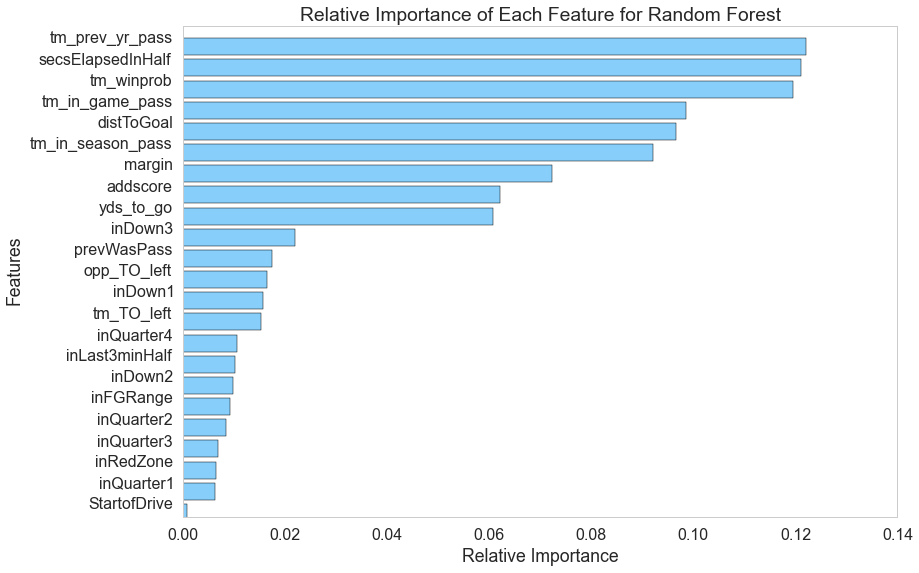

In [214]:
# make random forest plots
plot_features(clfForest,lcols,"Random Forest")

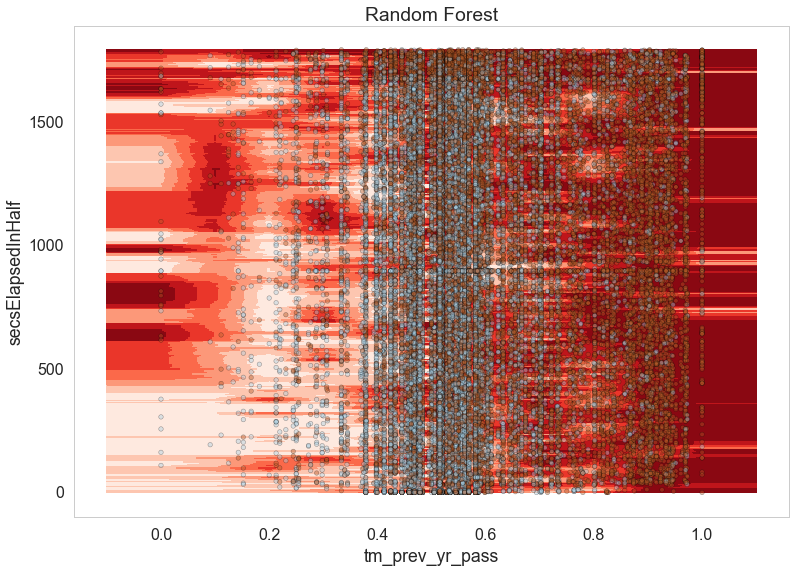

<type 'numpy.float64'> <type 'float'>


In [215]:
# make random forest plots
plot_rf(clfForest,"Random Forest",lcols,df)

In [262]:
# ADA Boost Classifier
from sklearn.ensemble import RandomForestClassifier
clfAda, Xtrainada, ytrainada, Xtestada, ytestada,_ = adaboost(RandomForestClassifier(n_estimators=33),df,lcols,mask) 

using mask
BEST {'n_estimators': 26} 0.75144948496 [mean: 0.74161, std: 0.00657, params: {'n_estimators': 1}, mean: 0.74929, std: 0.00508, params: {'n_estimators': 6}, mean: 0.75098, std: 0.00499, params: {'n_estimators': 11}, mean: 0.74948, std: 0.00663, params: {'n_estimators': 16}, mean: 0.75131, std: 0.00636, params: {'n_estimators': 21}, mean: 0.75145, std: 0.00462, params: {'n_estimators': 26}, mean: 0.74919, std: 0.00564, params: {'n_estimators': 31}, mean: 0.74843, std: 0.00576, params: {'n_estimators': 36}, mean: 0.74965, std: 0.00552, params: {'n_estimators': 41}, mean: 0.75086, std: 0.00502, params: {'n_estimators': 46}, mean: 0.75079, std: 0.00609, params: {'n_estimators': 51}, mean: 0.74836, std: 0.00553, params: {'n_estimators': 56}, mean: 0.74946, std: 0.00481, params: {'n_estimators': 61}, mean: 0.74846, std: 0.00445, params: {'n_estimators': 66}, mean: 0.74829, std: 0.00626, params: {'n_estimators': 71}, mean: 0.74953, std: 0.00471, params: {'n_estimators': 76}, mean: 

/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


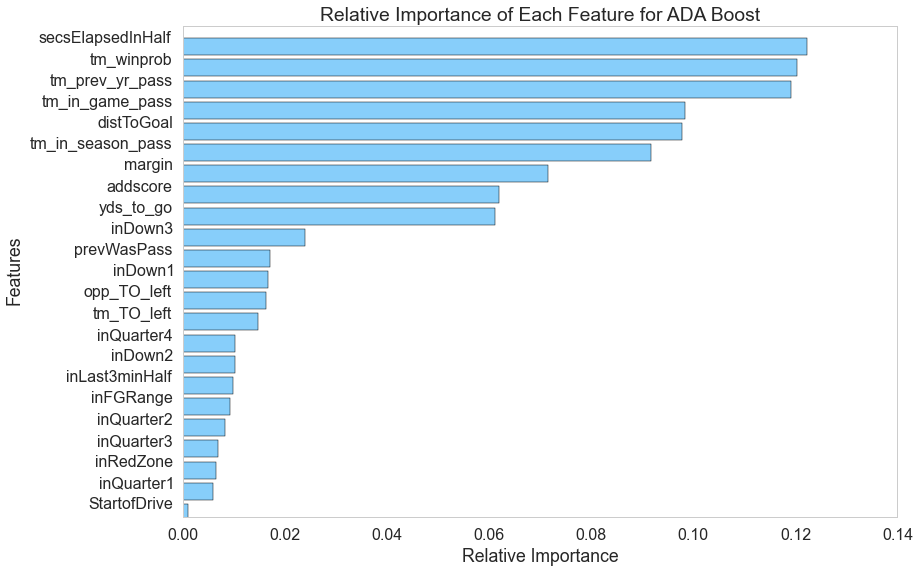

In [217]:
# make ada boost features plots
plot_features(clfAda,lcols,"ADA Boost")

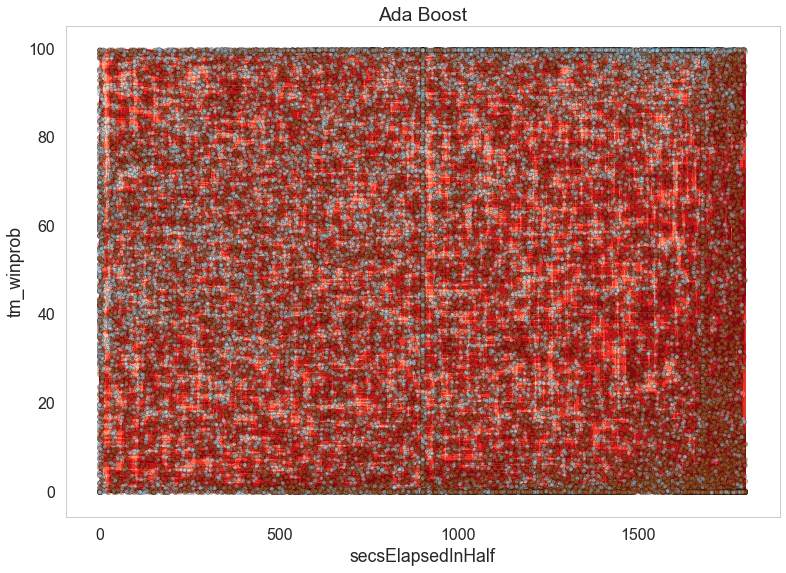

<type 'numpy.float64'> <type 'float'>


In [218]:
# make ada boost plots
plot_rf(clfAda,"Ada Boost",lcols,df)

In [254]:
# Gradient Boost CLassifier
clfGB, Xtraingb, ytraingb, Xtestgb, ytestgb,_ = gradboost(df,lcols,mask)

using mask
BEST {'max_depth': 3} 0.748515880401 [mean: 0.74427, std: 0.00367, params: {'max_depth': 1}, mean: 0.74694, std: 0.00461, params: {'max_depth': 2}, mean: 0.74852, std: 0.00249, params: {'max_depth': 3}, mean: 0.74709, std: 0.00628, params: {'max_depth': 4}, mean: 0.74577, std: 0.00509, params: {'max_depth': 5}, mean: 0.74513, std: 0.00761, params: {'max_depth': 6}, mean: 0.74342, std: 0.01055, params: {'max_depth': 7}]
############# based on standard predict ################
Accuracy on training data: 0.709889
Accuracy on test data:     0.706422
[[2554 1537]
 [1439 4607]]
########################################################
(23653, 23)
(10137, 23)


/Users/StevenRachesky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


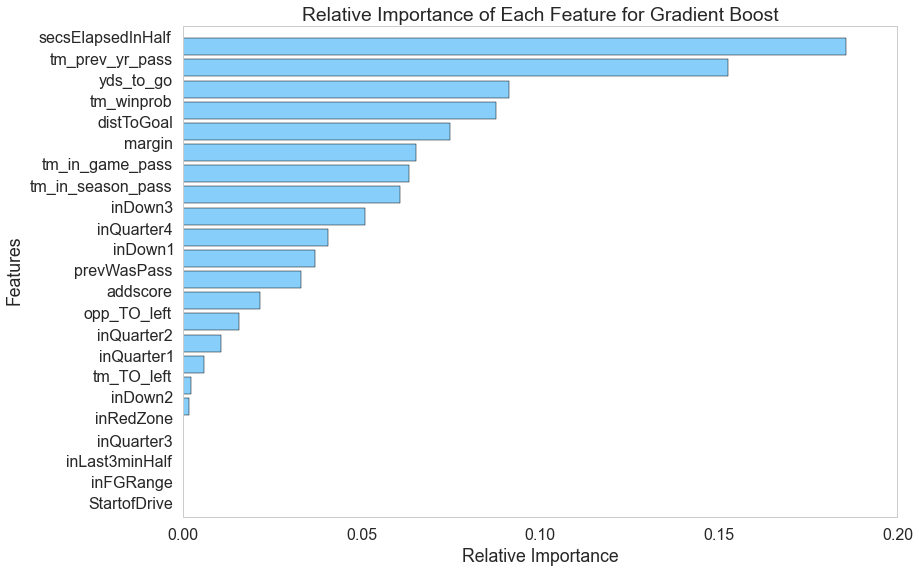

In [235]:
# make gradient boost features plots
plot_features(clfGB,lcols,"Gradient Boost")

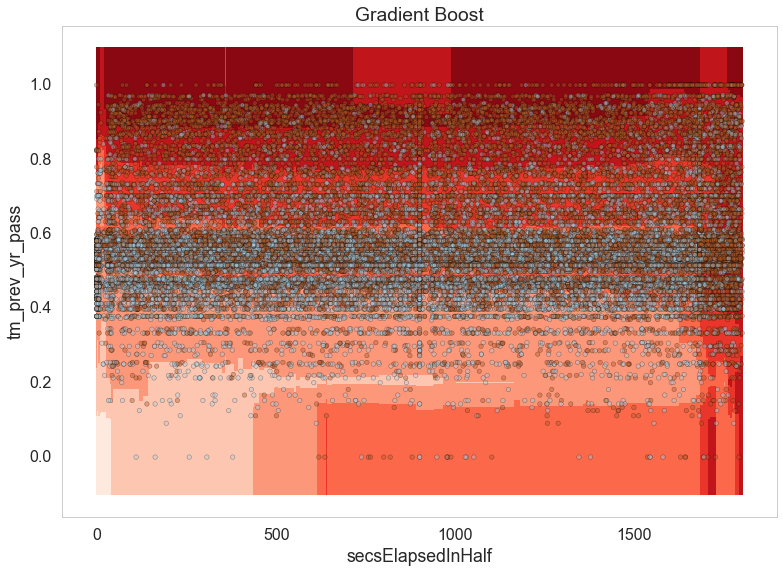

<type 'numpy.float64'> <type 'float'>


In [236]:
# make gradient boost plots
plot_rf(clfGB,"Gradient Boost",lcols,df)

In [259]:
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        preds = clf.predict_proba(xtest)[:,1]
        fpr, tpr, thresholds=roc_curve(ytest, preds)
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
        ax.grid(False)
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')
    ax.legend(loc="lower right")
    return ax

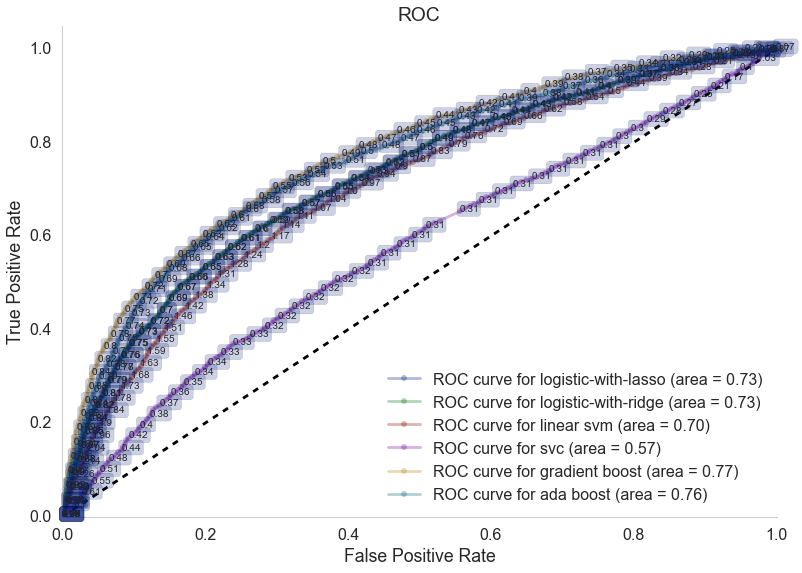

In [ ]:
with sns.color_palette("dark"):
    ax=make_roc("logistic-with-lasso",clflog, ytest1, Xtest1, labe=200, proba=True, skip=50)
    make_roc("logistic-with-ridge",clflog2, ytest2, Xtest2, ax, labe=200, proba=True, skip=50);
    make_roc("linear svm",clfsvm_lin, ytestlin, Xtestlin, ax, labe=200, proba=False, skip=50);
    make_roc("svc",clfsvm_orig, ytestorig, Xtestorig, ax, labe=200, proba=False, skip=50);
    make_roc("gradient boost",clfGB, ytestgb, Xtestgb, ax, labe=200, proba=True, skip=50);
    make_roc("ada boost",clfAda, ytestada, Xtestada, ax, labe=200, proba=True, skip=50);

In [ ]:
# Compile progression of quick classifier's performance
years = np.arange(2003,2015)
svm_ = []
log_lasso = []
log_ridge = []
rf = []
gb = []
for yr in years:
    dfp = completedf[completedf['year']==year]
    _, _, _, _, _,svm_acc = runsvm2(dfp, lcols, mask, Cs)
    _, _, _, _, _,log_lasso_acc = do_classify(LogisticRegression(penalty="l1"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df, lcols, u'RESP', 1, mask=mask)
    _, _, _, _, _,log_ridge_acc = do_classify(LogisticRegression(penalty="l2"), {"C": [0.001, 0.01, 0.1, 1, 10, 100]}, df, lcols, u'RESP', 1, mask=mask)
    _, _, _, _, _,rf_acc = randforest(df,lcols,mask)
    _, _, _, _, _,gb_acc = gradboost(df,lcols,mask)
    svm_.append(svm_acc)
    log_lasso.append(log_lasso_acc)
    log_ridge.append(log_ridge)
    rf.append(rf_acc)
    gb.append(gb_acc)
performance = [svm_,log_lasso,log_ridge,rf,gb]

using mask
BEST {'C': 100.0} 0.590284530504 [mean: 0.58077, std: 0.04416, params: {'C': 0.001}, mean: 0.56306, std: 0.05679, params: {'C': 0.01}, mean: 0.57024, std: 0.07273, params: {'C': 0.1}, mean: 0.52759, std: 0.08777, params: {'C': 1.0}, mean: 0.56027, std: 0.07578, params: {'C': 10.0}, mean: 0.59028, std: 0.04393, params: {'C': 100.0}]
############# based on standard predict ################
Accuracy on training data: 0.608675
Accuracy on test data:     0.608957
[[ 312 3779]
 [ 185 5861]]
########################################################
using mask
BEST {'C': 0.1} 0.66773770769 [mean: 0.59785, std: 0.01166, params: {'C': 0.001}, mean: 0.65818, std: 0.01221, params: {'C': 0.01}, mean: 0.66774, std: 0.01113, params: {'C': 0.1}, mean: 0.66736, std: 0.00911, params: {'C': 1}, mean: 0.66765, std: 0.00933, params: {'C': 10}, mean: 0.66774, std: 0.00982, params: {'C': 100}]
############# based on standard predict ################
Accuracy on training data: 0.669640
Accuracy on t

In [ ]:
# Display progression
N = len(performance)
labels = ["svm", "logistic-lasso", "logistic-ridge", "random forest", "gradient boost"]
for i in range(N):
    plt.plot(years, i, label = labels[i], lw=1, ls = "-")
plt.grid(False)
plt.xlabel("Years")
plt.ylabel("Classifier accuracy on test set")
plt.title("Progression of Classifier Accuracy")
sns.despine()
plt.legend(loc="best")